<a href="https://colab.research.google.com/github/Nitroblaster99/pneumonia_detection_CNN/blob/main/Pneumonia_Detection_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Upload data

In [1]:
! pip install -q kaggle

In [ ]:
from google.colab import files

files.upload()

In [ ]:
! mkdir ~/.kaggle

! cp kaggle.json ~/.kaggle/

In [4]:
! chmod 600 /root/.kaggle/kaggle.json

In [ ]:
! kaggle datasets download paultimothymooney/chest-xray-pneumonia

In [ ]:
! unzip chest-xray-pneumonia.zip

In [8]:
!ls chest_xray/chest_xray

test  train  val


Import libraries

In [9]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow import keras

Search and make file directories

In [10]:
os.listdir("../content")

['.config',
 'kaggle (1).json',
 'kaggle.json',
 'chest_xray',
 'chest-xray-pneumonia.zip',
 'sample_data']

In [11]:
for dirpath, dirnames, filenames in os.walk("chest_xray/chest_xray"):
  print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

There are 3 directories and 1 images in 'chest_xray/chest_xray'.
There are 2 directories and 1 images in 'chest_xray/chest_xray/train'.
There are 0 directories and 1342 images in 'chest_xray/chest_xray/train/NORMAL'.
There are 0 directories and 3876 images in 'chest_xray/chest_xray/train/PNEUMONIA'.
There are 2 directories and 1 images in 'chest_xray/chest_xray/val'.
There are 0 directories and 9 images in 'chest_xray/chest_xray/val/NORMAL'.
There are 0 directories and 9 images in 'chest_xray/chest_xray/val/PNEUMONIA'.
There are 2 directories and 1 images in 'chest_xray/chest_xray/test'.
There are 0 directories and 234 images in 'chest_xray/chest_xray/test/NORMAL'.
There are 0 directories and 390 images in 'chest_xray/chest_xray/test/PNEUMONIA'.


In [12]:
train_dir = "chest_xray/chest_xray/train/"
val_dir = "chest_xray/chest_xray/val"
test_dir = "chest_xray/chest_xray/test/"

Data Visaulization

In [13]:
print('Train set::\n=================')
num_pneumonia = len(os.listdir(os.path.join(train_dir, 'PNEUMONIA')))
num_normal = len(os.listdir(os.path.join(train_dir, 'NORMAL')))
print(f"PNEUMONIA={num_pneumonia}")
print(f"NORMAL={num_normal}")
print('\n')
print('Test set::\n=================')
print(f"PNEUMONIA={len(os.listdir(os.path.join(test_dir, 'PNEUMONIA')))}")
print(f"NORMAL={len(os.listdir(os.path.join(test_dir, 'NORMAL')))}")
print('\n')
print('Val set::\n=================')
print(f"PNEUMONIA={len(os.listdir(os.path.join(val_dir, 'PNEUMONIA')))}")
print(f"NORMAL={len(os.listdir(os.path.join(val_dir, 'NORMAL')))}")


Train set::
PNEUMONIA=3876
NORMAL=1342


Test set::
PNEUMONIA=390
NORMAL=234


Val set::
PNEUMONIA=9
NORMAL=9


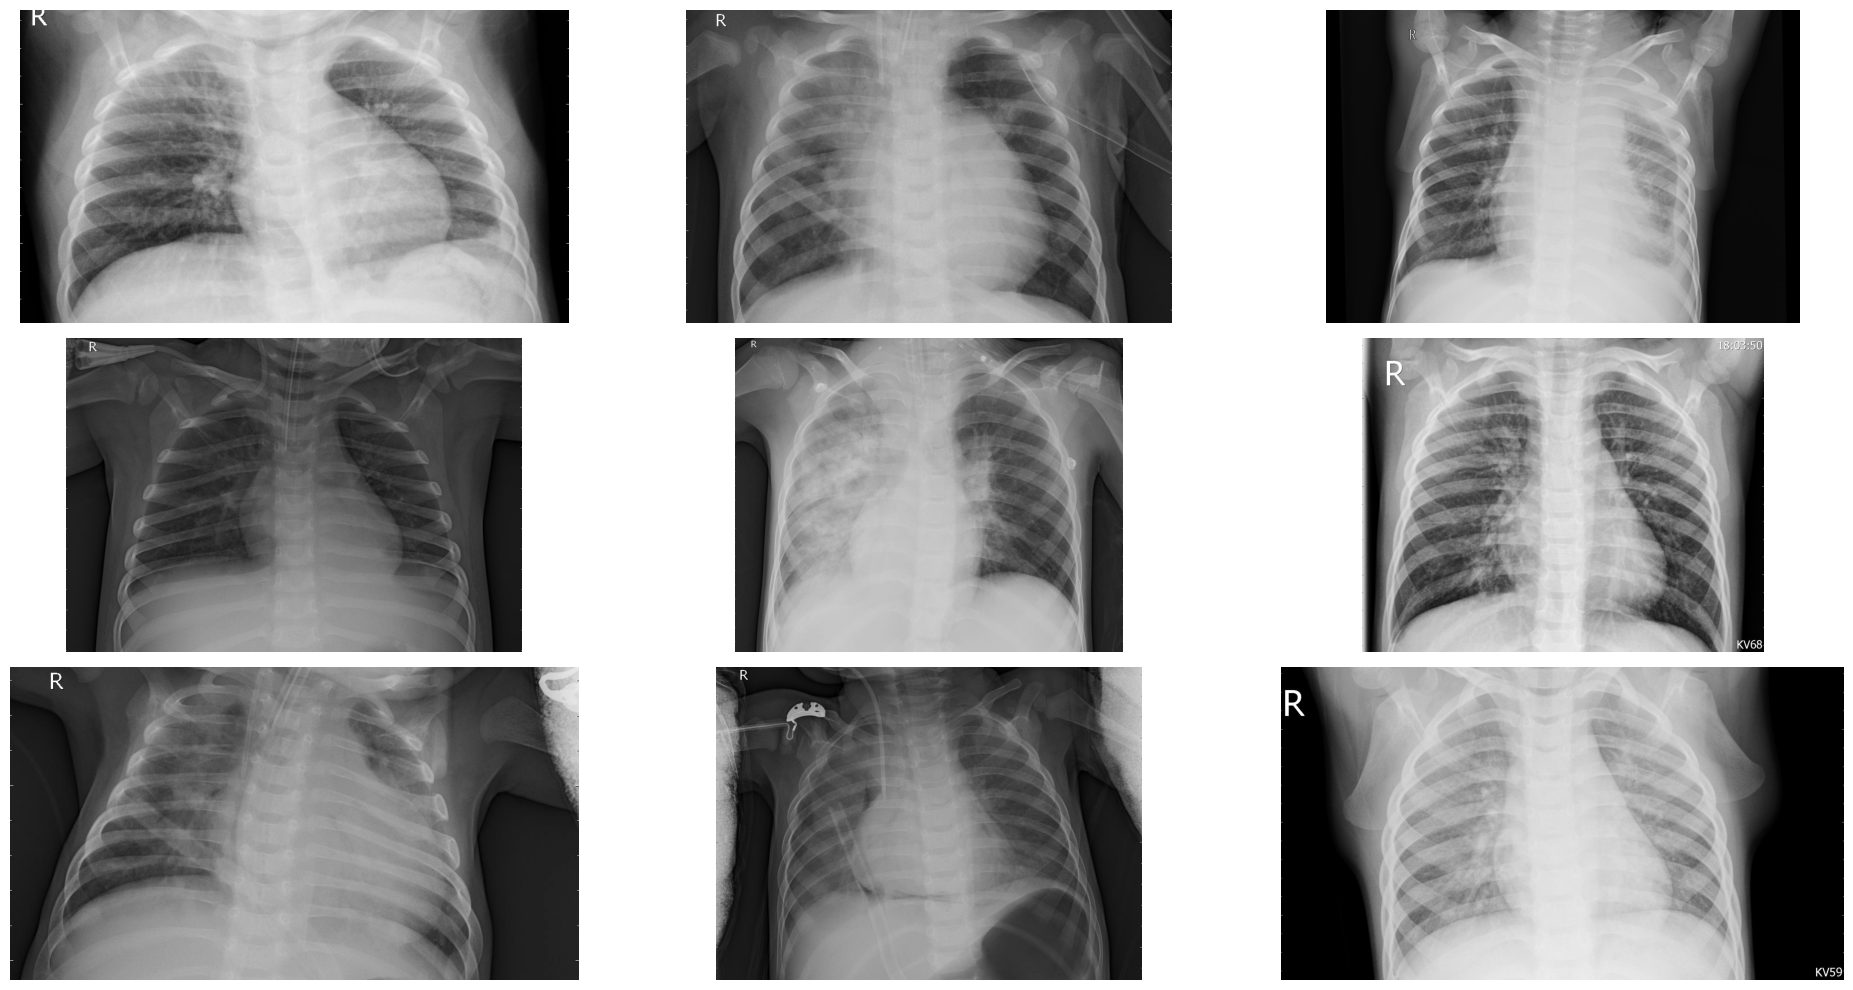

In [14]:
pneumonia = os.listdir("chest_xray/chest_xray/train/PNEUMONIA")
penumonia_dir = "chest_xray/chest_xray/train/PNEUMONIA"

plt.figure(figsize=(20,10))

for i in range(9):
  plt.subplot(3,3,i+1)
  img=plt.imread(os.path.join(penumonia_dir, pneumonia[i]))
  plt.imshow(img,cmap='gray')
  plt.axis('off')

plt.tight_layout()

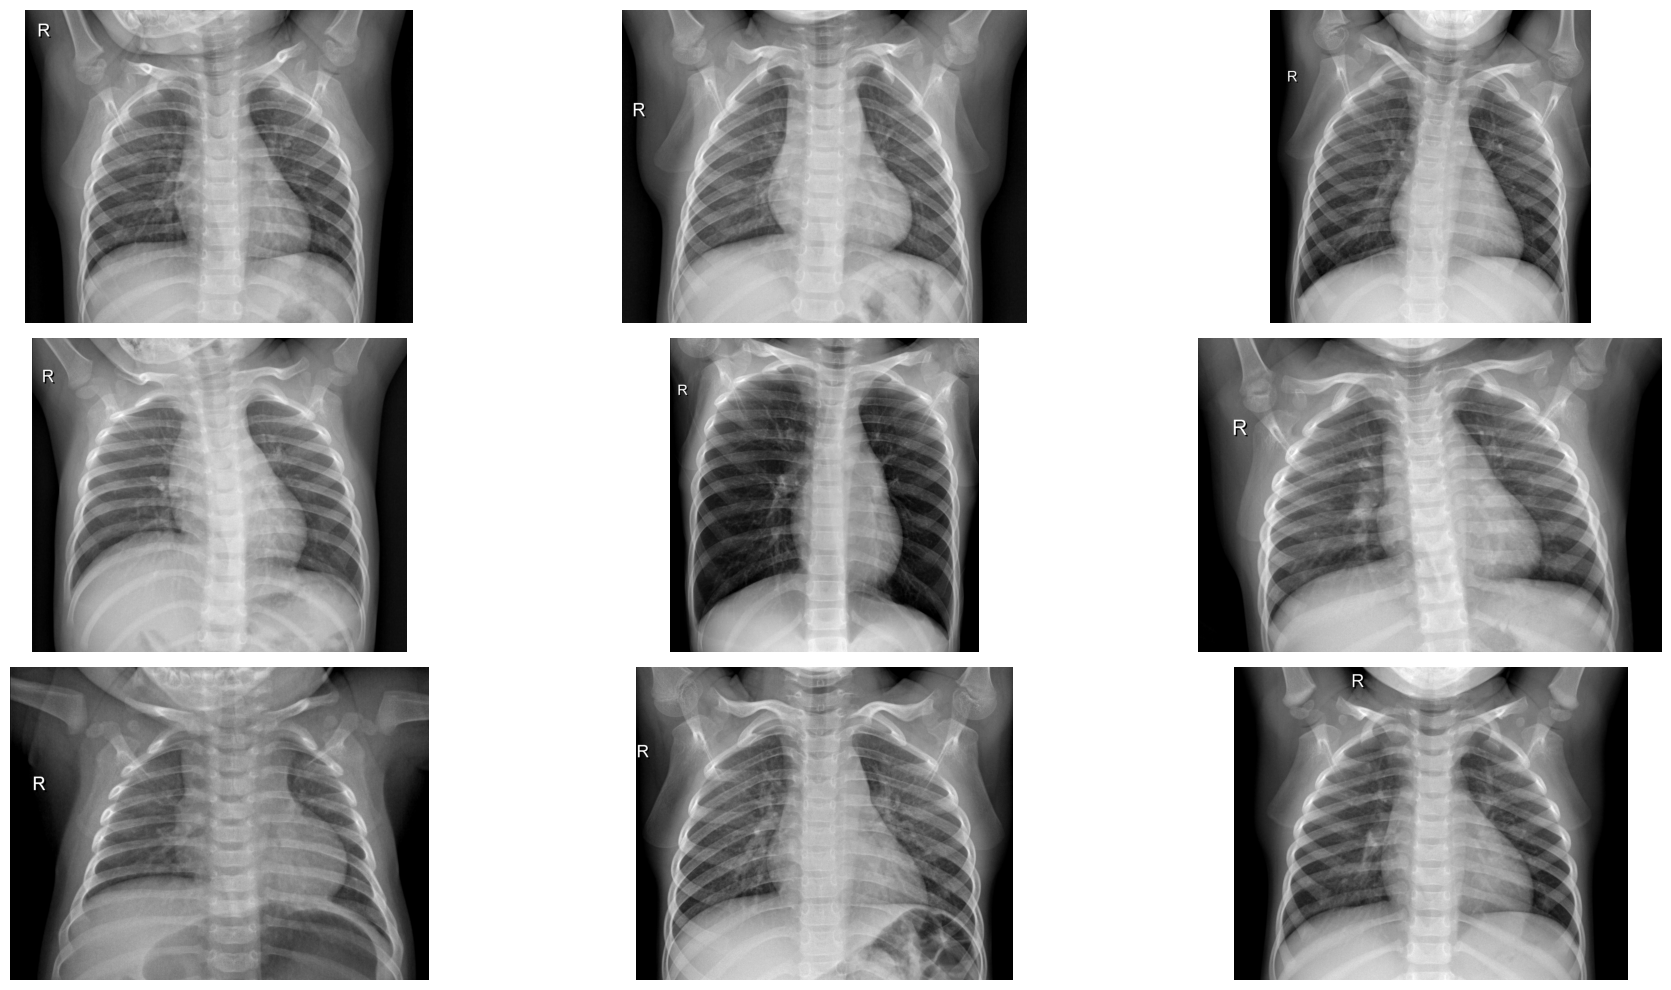

In [15]:
normal = os.listdir("chest_xray/chest_xray/train/NORMAL")
normal_dir = "chest_xray/chest_xray/train/NORMAL"

plt.figure(figsize=(20, 10))

for i in range(9):
    plt.subplot(3, 3, i + 1)
    img = plt.imread(os.path.join(normal_dir, normal[i]))
    plt.imshow(img, cmap='gray')
    plt.axis('off')

plt.tight_layout()

The dimensions of the image are 1395 pixels width and 1724 pixels height, one single color channel.
The maximum pixel value is 255.0000 and the minimum is 0.0000
The mean value of the pixels is 115.0927 and the standard deviation is 60.2108


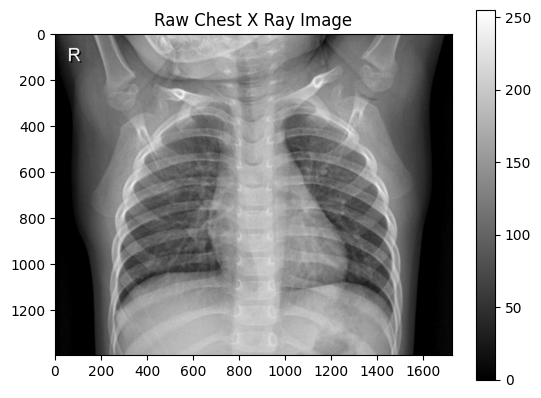

In [16]:
normal_img = os.listdir("chest_xray/chest_xray/train/NORMAL")[0]
normal_dir = "chest_xray/chest_xray/train/NORMAL"
sample_img = plt.imread(os.path.join(normal_dir, normal_img))
plt.imshow(sample_img, cmap='gray')
plt.colorbar()
plt.title('Raw Chest X Ray Image')

print(f"The dimensions of the image are {sample_img.shape[0]} pixels width and {sample_img.shape[1]} pixels height, one single color channel.")
print(f"The maximum pixel value is {sample_img.max():.4f} and the minimum is {sample_img.min():.4f}")
print(f"The mean value of the pixels is {sample_img.mean():.4f} and the standard deviation is {sample_img.std():.4f}")

Investigate pixel value distribution

<ipython-input-17-d45ac08d2db9>:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(sample_img.ravel(),


Text(0, 0.5, '# Pixels in Image')

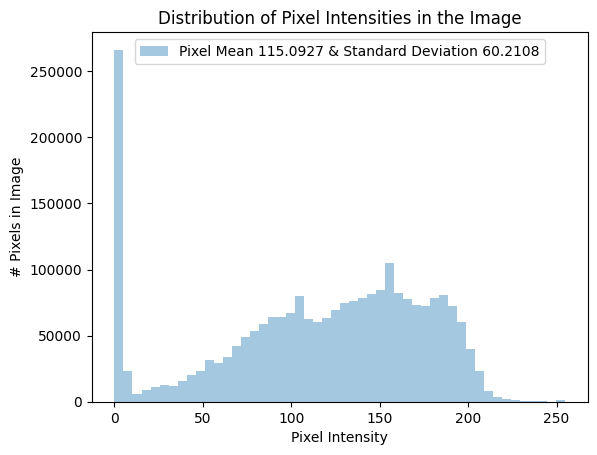

In [17]:
sns.distplot(sample_img.ravel(),
            label=f"Pixel Mean {np.mean(sample_img):.4f} & Standard Deviation {np.std(sample_img):.4f}", kde=False)
plt.legend(loc='upper center')
plt.title('Distribution of Pixel Intensities in the Image')
plt.xlabel('Pixel Intensity')
plt.ylabel('# Pixels in Image')

Image Preprocessing - Augmentation

In [18]:
from keras.preprocessing.image import ImageDataGenerator

image_generator = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    shear_range=0.1,
    zoom_range=0.1,
    samplewise_center=True,
    samplewise_std_normalization=True
)

Building separate generators

In [19]:
train = image_generator.flow_from_directory(train_dir,
                                            batch_size=8,
                                            shuffle=True,
                                            class_mode='binary',
                                            target_size=(180,180))
validation = image_generator.flow_from_directory(val_dir,
                                                 batch_size=1,
                                                 shuffle=True,
                                                 class_mode='binary',
                                                 target_size=(180,180))
test = image_generator.flow_from_directory(test_dir,
                                            batch_size=1,
                                            shuffle=False,
                                            class_mode='binary',
                                            target_size=(180, 180))

Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


The dimensions of the image are 180 pixels width and 180 pixels height, one single color channel.
The maximum pixel value is 2.9570 and the minimum is -4.4941
The mean value of the pixel is -0.0000 and the standard deviation is 1.0000


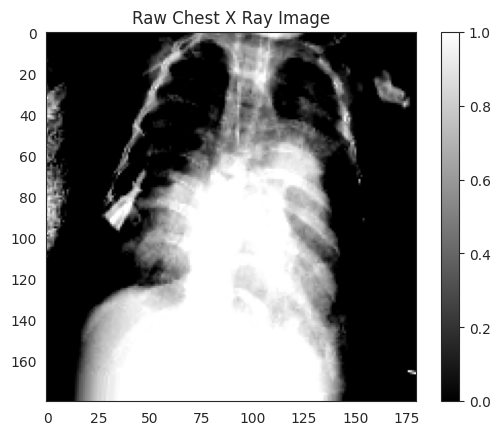

In [20]:
sns.set_style('white')
generated_image, label = train.__getitem__(0)
plt.imshow(generated_image[0], cmap='gray')
plt.colorbar()
plt.title('Raw Chest X Ray Image')

print(f"The dimensions of the image are {generated_image.shape[1]} pixels width and {generated_image.shape[2]} pixels height, one single color channel.")
print(f"The maximum pixel value is {generated_image.max():.4f} and the minimum is {generated_image.min():.4f}")
print(f"The mean value of the pixel is {generated_image.mean():.4f} and the standard deviation is {generated_image.std():.4f}")

When we have an imbalance data, using a normal loss function will result a model that bias toward the dominating class. One solution is to use a weighted loss function. Using weighted loss function will balance the contribution in the loss function.

In [21]:
# Class weights

weight_for_0 = num_pneumonia / (num_normal + num_pneumonia)
weight_for_1 = num_normal / (num_normal + num_pneumonia)

class_weight = {0: weight_for_0, 1: weight_for_1}

print(f"Weight for class 0: {weight_for_0:.2f}")
print(f"Weight for class 1: {weight_for_1:.2f}")

Weight for class 0: 0.74
Weight for class 1: 0.26


CNN Model

In [22]:
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPool2D, Dropout, Flatten, BatchNormalization

In [23]:
model = Sequential()

model.add(Conv2D(filters=32, kernel_size=(3,3), input_shape=(180,180,3),
                 activation='relu'))
model.add(BatchNormalization())
model.add(Conv2D(filters=32, kernel_size=(3,3), input_shape=(180,180,3),
                 activation='relu'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2,2)))

model.add(Conv2D(filters=64, kernel_size=(3,3), activation='relu'))
model.add(BatchNormalization())
model.add(Conv2D(filters=64, kernel_size=(3,3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.2))

model.add(Conv2D(filters=128, kernel_size=(3,3), activation='relu'))
model.add(BatchNormalization())
model.add(Conv2D(filters=128, kernel_size=(3,3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.2))

model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.2))

model.add(Dense(1, activation='sigmoid'))

In [24]:
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [25]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 178, 178, 32)      896       
                                                                 
 batch_normalization (Batch  (None, 178, 178, 32)      128       
 Normalization)                                                  
                                                                 
 conv2d_1 (Conv2D)           (None, 176, 176, 32)      9248      
                                                                 
 batch_normalization_1 (Bat  (None, 176, 176, 32)      128       
 chNormalization)                                                
                                                                 
 max_pooling2d (MaxPooling2  (None, 88, 88, 32)        0         
 D)                                                              
                                                        

In [26]:
hist = model.fit(
    train,
    epochs=10,
    validation_data=validation,
    class_weight=class_weight
)

Epoch 1/10
652/652 [==============================] - 101s 141ms/step - loss: 0.3614 - accuracy: 0.8175 - val_loss: 2.8709 - val_accuracy: 0.5625
Epoch 2/10
652/652 [==============================] - 92s 141ms/step - loss: 0.1144 - accuracy: 0.8691 - val_loss: 0.5077 - val_accuracy: 0.6250
Epoch 3/10
652/652 [==============================] - 92s 141ms/step - loss: 0.0986 - accuracy: 0.8806 - val_loss: 0.8474 - val_accuracy: 0.5625
Epoch 4/10
652/652 [==============================] - 92s 141ms/step - loss: 0.0968 - accuracy: 0.8896 - val_loss: 0.5912 - val_accuracy: 0.6250
Epoch 5/10
652/652 [==============================] - 92s 141ms/step - loss: 0.1042 - accuracy: 0.8936 - val_loss: 0.6498 - val_accuracy: 0.7500
Epoch 6/10
652/652 [==============================] - 92s 142ms/step - loss: 0.1199 - accuracy: 0.8995 - val_loss: 0.4636 - val_accuracy: 0.7500
Epoch 7/10
652/652 [==============================] - 113s 174ms/step - loss: 0.0905 - accuracy: 0.9178 - val_loss: 1.5346 - val_

Evaluation

Text(0.5, 1.0, 'Accuracy Evolution')

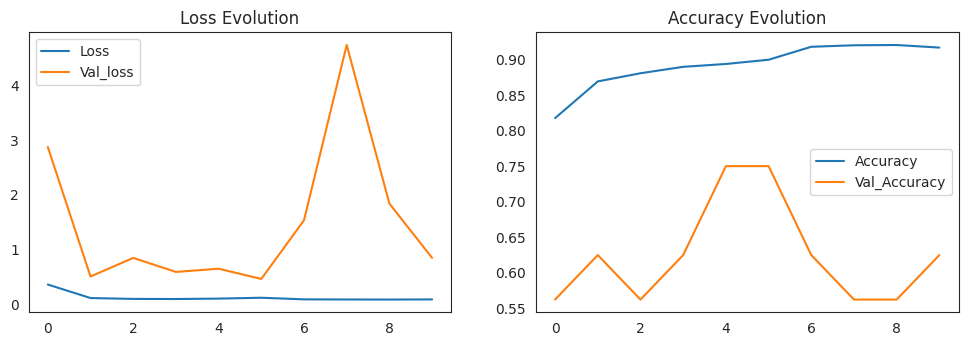

In [27]:
plt.figure(figsize=(12,8))

plt.subplot(2,2,1)
plt.plot(hist.history['loss'], label='Loss')
plt.plot(hist.history['val_loss'], label='Val_loss')
plt.legend()
plt.title('Loss Evolution')

plt.subplot(2,2,2)
plt.plot(hist.history['accuracy'], label='Accuracy')
plt.plot(hist.history['val_accuracy'], label='Val_Accuracy')
plt.legend()
plt.title('Accuracy Evolution')

In [28]:
evaluation = model.evaluate(test)
print(f"Test Accuracy: {evaluation[1]*100:.2f}%")

evaluation = model.evaluate(train)
print(f"Train Accuaracy: {evaluation[1]*100:.2f}%")

624/624 [==============================] - 10s 16ms/step - loss: 0.3861 - accuracy: 0.8381
Test Accuracy: 83.81%
652/652 [==============================] - 82s 125ms/step - loss: 0.1764 - accuracy: 0.9371
Train Accuaracy: 93.71%


In [29]:
from sklearn.metrics import confusion_matrix, classification_report

pred = model.predict(test)

624/624 [==============================] - 10s 17ms/step


In [30]:
print(confusion_matrix(test.classes, pred>0.7))
pd.DataFrame(classification_report(test.classes, pred>0.7, output_dict=True))

[[192  42]
 [ 35 355]]


,0,1,accuracy,macro avg,weighted avg
precision,0.845815,0.894207,0.876603,0.870011,0.876060
recall,0.820513,0.910256,0.876603,0.865385,0.876603
f1-score,0.832972,0.902160,0.876603,0.867566,0.876214
support,234.000000,390.000000,0.876603,624.000000,624.000000


Transfer Learning
using DenseNEt

In [31]:
from keras.applications.densenet import DenseNet121
from keras.layers import Dense, GlobalAveragePooling2D
from keras.models import Model
from keras import backend as K

In [32]:
base_model = DenseNet121(input_shape=(180,180,3), include_top=False,
                         weights='imagenet', pooling='avg')

base_model.summary()

Model: "densenet121"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 180, 180, 3)]        0         []                            
                                                                                                  
 zero_padding2d (ZeroPaddin  (None, 186, 186, 3)          0         ['input_1[0][0]']             
 g2D)                                                                                             
                                                                                                  
 conv1/conv (Conv2D)         (None, 90, 90, 64)           9408      ['zero_padding2d[0][0]']      
                                                                                                  
 conv1/bn (BatchNormalizati  (None, 90, 90, 64)           256       ['conv1/conv[0][0]']

In [33]:
layers = base_model.layers
print(f"The model has {len(layers)} layers")

The model has 428 layers


In [34]:
print(f"The input shape {base_model.input}")
print(f"The output shape {base_model.output}")

The input shape KerasTensor(type_spec=TensorSpec(shape=(None, 180, 180, 3), dtype=tf.float32, name='input_1'), name='input_1', description="created by layer 'input_1'")
The output shape KerasTensor(type_spec=TensorSpec(shape=(None, 1024), dtype=tf.float32, name=None), name='avg_pool/Mean:0', description="created by layer 'avg_pool'")


In [35]:
base_model = DenseNet121(include_top=False, weights='imagenet')
x = base_model.output

x = GlobalAveragePooling2D()(x)

predictions = Dense(1, activation='sigmoid')(x)

model = Model(inputs=base_model.input, outputs=predictions)

model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [36]:
hist = model.fit(
    train,
    epochs=10,
    validation_data=validation,
    class_weight=class_weight
)

Epoch 1/10
652/652 [==============================] - 177s 175ms/step - loss: 0.1175 - accuracy: 0.8694 - val_loss: 0.7308 - val_accuracy: 0.6875
Epoch 2/10
652/652 [==============================] - 113s 173ms/step - loss: 0.0930 - accuracy: 0.8959 - val_loss: 0.2886 - val_accuracy: 0.8125
Epoch 3/10
652/652 [==============================] - 110s 169ms/step - loss: 0.0752 - accuracy: 0.9225 - val_loss: 0.4776 - val_accuracy: 0.7500
Epoch 4/10
652/652 [==============================] - 113s 174ms/step - loss: 0.0638 - accuracy: 0.9317 - val_loss: 0.6265 - val_accuracy: 0.7500
Epoch 5/10
652/652 [==============================] - 111s 171ms/step - loss: 0.0636 - accuracy: 0.9304 - val_loss: 0.6558 - val_accuracy: 0.5625
Epoch 6/10
652/652 [==============================] - 112s 172ms/step - loss: 0.0558 - accuracy: 0.9461 - val_loss: 0.3836 - val_accuracy: 0.8750
Epoch 7/10
652/652 [==============================] - 112s 171ms/step - loss: 0.0545 - accuracy: 0.9421 - val_loss: 1.1925 -

Evaluation after Transfer Learning

Text(0.5, 1.0, 'Accuracy Evolution')

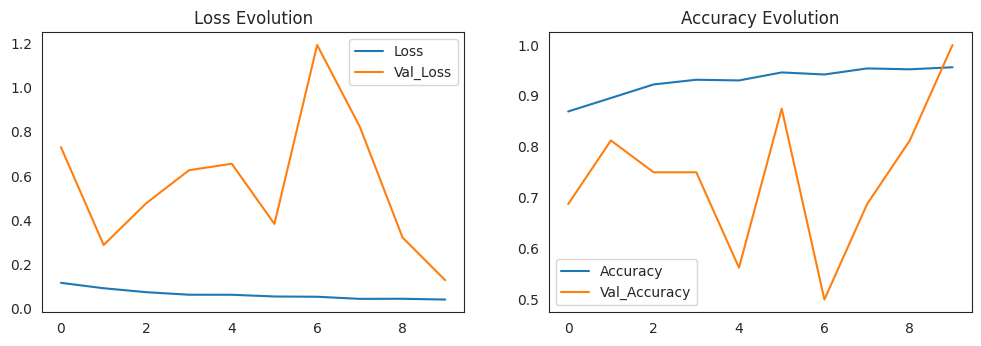

In [37]:
plt.figure(figsize=(12, 8))

plt.subplot(2, 2, 1)
plt.plot(hist.history['loss'], label='Loss')
plt.plot(hist.history['val_loss'], label='Val_Loss')
plt.legend()
plt.title('Loss Evolution')

plt.subplot(2, 2, 2)
plt.plot(hist.history['accuracy'], label='Accuracy')
plt.plot(hist.history['val_accuracy'], label='Val_Accuracy')
plt.legend()
plt.title('Accuracy Evolution')

In [38]:
evaluation = model.evaluate(test)
print(f"Test Accuracy: {evaluation[1] * 100:.2f}%")

evaluation = model.evaluate(train)
print(f"Train Accuracy: {evaluation[1] * 100:.2f}%")

624/624 [==============================] - 16s 26ms/step - loss: 0.2578 - accuracy: 0.9054
Test Accuracy: 90.54%
652/652 [==============================] - 90s 138ms/step - loss: 0.2079 - accuracy: 0.9162
Train Accuracy: 91.62%


In [39]:
predicted_vals = model.predict(test, steps=len(test))

624/624 [==============================] - 18s 27ms/step


In [55]:
print(confusion_matrix(test.classes, predicted_vals > 0.5))
pd.DataFrame(classification_report(test.classes, predicted_vals > 0.5,
                                   output_dict=True))

[[199  35]
 [ 26 364]]


,0,1,accuracy,macro avg,weighted avg
precision,0.884444,0.912281,0.902244,0.898363,0.901842
recall,0.850427,0.933333,0.902244,0.891880,0.902244
f1-score,0.867102,0.922687,0.902244,0.894895,0.901843
support,234.000000,390.000000,0.902244,624.000000,624.000000
